# Feature Selection with LightGBM

**Objective**: Use LightGBM feature importance to identify and select the most predictive features.

**Strategy**:
1. Train baseline LightGBM model with all engineered features
2. Extract gain-based feature importance
3. Iteratively prune low-importance features (bottom 20%)
4. Monitor validation metrics to avoid over-pruning
5. Save final selected feature list

**Target**: Reduce from ~230 features to ~60-80 features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import json
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')

print('Libraries loaded successfully')

Libraries loaded successfully


## Section 1: Load Engineered Data

In [2]:
# Load engineered datasets
df_stable = pd.read_csv('../data/hull-tactical-market-prediction/train_no_missing_2007_2025_engineered.csv')
df_recent = pd.read_csv('../data/hull-tactical-market-prediction/train_2018_2025_engineered.csv')

print('='*80)
print('DATA LOADED')
print('='*80)
print(f'\nStable (2007-2025): {df_stable.shape}')
print(f'Recent (2018-2025): {df_recent.shape}')

# We'll focus on Stable dataset for feature selection (more data)
df = df_stable.copy()
print(f'\nUsing Stable dataset for feature selection')
print('='*80)

DATA LOADED

Stable (2007-2025): (4625, 659)
Recent (2018-2025): (1872, 682)

Using Stable dataset for feature selection


## Section 2: Prepare Features and Target

In [3]:
# Define target and exclude columns
target_col = 'market_forward_excess_returns'
exclude_cols = ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']

# Also exclude any non-lagged target derivatives if they slipped through (safety check)
# We only want to keep lagged versions of the target
for col in df.columns:
    if 'market_forward_excess_returns' in col and 'lag' not in col and col != target_col:
        exclude_cols.append(col)

# Get feature columns
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f'Target: {target_col}')
print(f'Total features: {len(feature_cols)}')

# Check for leakage
leakage_candidates = [c for c in feature_cols if 'market_forward_excess_returns' in c and 'lag' not in c]
if leakage_candidates:
    print(f"WARNING: Potential leakage features found: {leakage_candidates}")
else:
    print("✓ No obvious leakage features found (all target derivatives are lagged)")

print(f'\nFeature categories:')
for prefix in ['D', 'E', 'I', 'M', 'P', 'S', 'V']:
    count = len([col for col in feature_cols if col.startswith(prefix)])
    if count > 0:
        print(f'  {prefix}-features: {count}')

# Prepare X and y
X = df[feature_cols]
y = df[target_col]

print(f'\nX shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'y mean: {y.mean():.6f}, y std: {y.std():.6f}')

Target: market_forward_excess_returns
Total features: 647
✓ No obvious leakage features found (all target derivatives are lagged)

Feature categories:
  D-features: 9
  E-features: 20
  I-features: 19
  M-features: 42
  P-features: 468
  S-features: 11
  V-features: 66

X shape: (4625, 647)
y shape: (4625,)
y mean: 0.000135, y std: 0.010994


## Section 3: Train Baseline LightGBM Model

In [4]:
# Time Series Cross-Validation setup
tscv = TimeSeriesSplit(n_splits=5)

# LightGBM parameters (conservative for baseline)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

print('='*80)
print('BASELINE MODEL TRAINING')
print('='*80)
print(f'\nParameters: {params}')
print(f'Cross-validation: {tscv.n_splits} folds')

# Train and collect feature importance
feature_importance_list = []
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Create datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    # Train
    model = lgb.train(
        params,
        train_data,
        num_boost_round=500,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    cv_scores.append(rmse)
    
    # Collect feature importance
    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importance(importance_type='gain')
    })
    feature_importance_list.append(importance)
    
    print(f'Fold {fold}: RMSE = {rmse:.6f}, Best iteration = {model.best_iteration}')

# Average feature importance across folds
feature_importance_df = pd.concat(feature_importance_list).groupby('feature').mean().reset_index()
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

print(f'\nCV RMSE: {np.mean(cv_scores):.6f} ± {np.std(cv_scores):.6f}')
print('='*80)

BASELINE MODEL TRAINING

Parameters: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': -1, 'random_state': 42}
Cross-validation: 5 folds


Fold 1: RMSE = 0.011282, Best iteration = 8


Fold 2: RMSE = 0.007904, Best iteration = 1


Fold 3: RMSE = 0.008028, Best iteration = 1


Fold 4: RMSE = 0.011403, Best iteration = 1


Fold 5: RMSE = 0.010858, Best iteration = 1

CV RMSE: 0.009895 ± 0.001586


## Section 4: Visualize Feature Importance

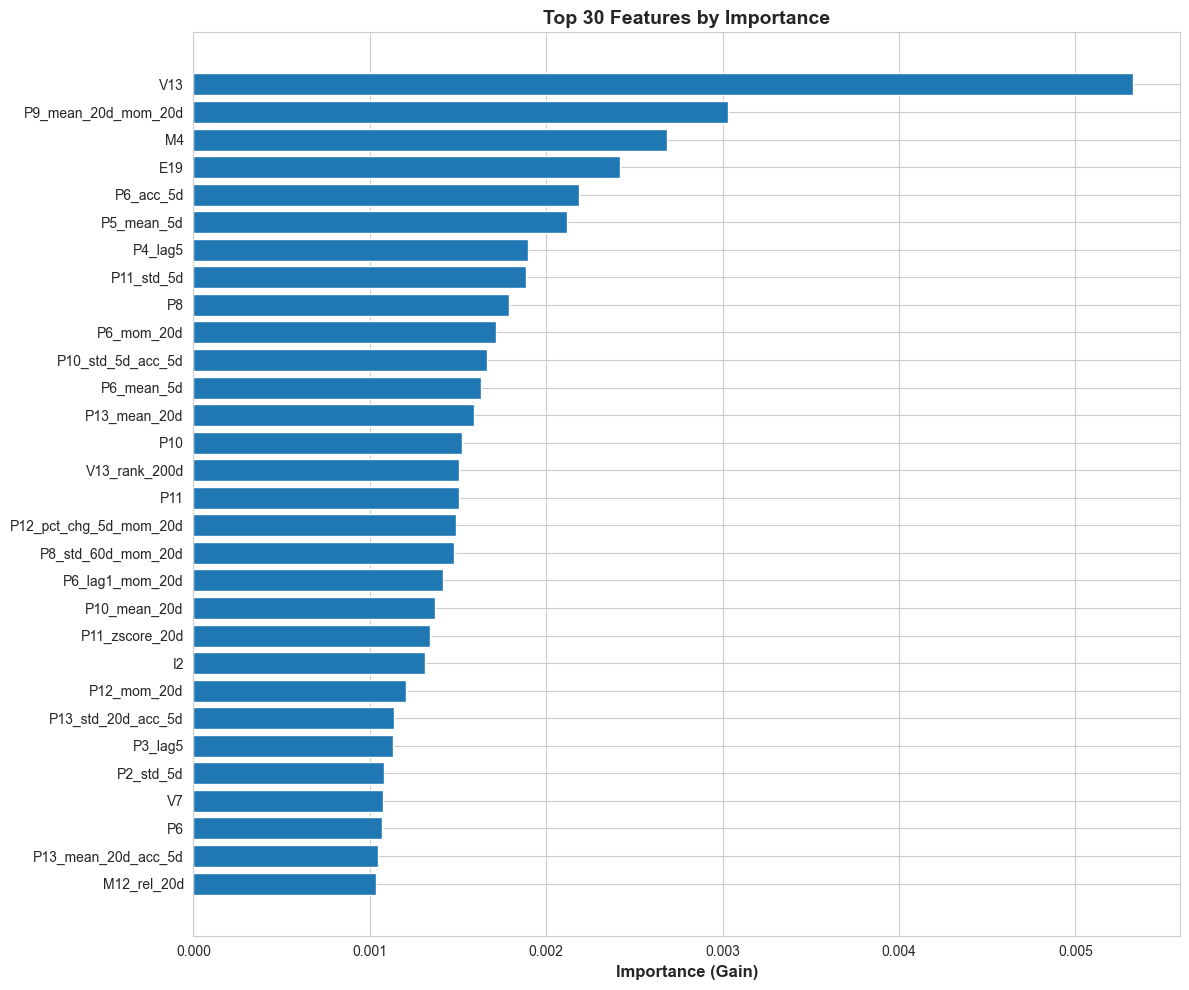


Top 20 Most Important Features:
               feature  importance
                   V13    0.005327
   P9_mean_20d_mom_20d    0.003031
                    M4    0.002683
                   E19    0.002416
             P6_acc_5d    0.002185
            P5_mean_5d    0.002117
               P4_lag5    0.001896
            P11_std_5d    0.001884
                    P8    0.001792
            P6_mom_20d    0.001713
     P10_std_5d_acc_5d    0.001664
            P6_mean_5d    0.001630
          P13_mean_20d    0.001588
                   P10    0.001523
         V13_rank_200d    0.001507
                   P11    0.001504
P12_pct_chg_5d_mom_20d    0.001488
    P8_std_60d_mom_20d    0.001477
       P6_lag1_mom_20d    0.001413
          P10_mean_20d    0.001371


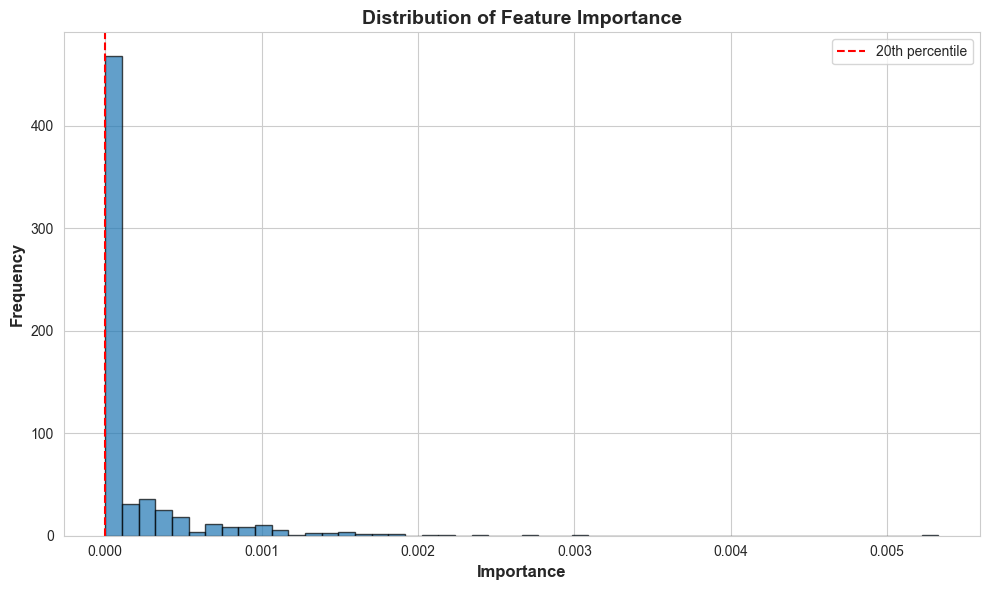


Importance Statistics:
count    647.000000
mean       0.000181
std        0.000441
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000176
max        0.005327
Name: importance, dtype: float64


In [5]:
# Plot top 30 features
fig, ax = plt.subplots(figsize=(12, 10))
top_features = feature_importance_df.head(30)
ax.barh(top_features['feature'], top_features['importance'])
ax.set_xlabel('Importance (Gain)', fontsize=12, fontweight='bold')
ax.set_title('Top 30 Features by Importance', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../analysis/feature_importance_top30.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nTop 20 Most Important Features:')
print(feature_importance_df.head(20)[['feature', 'importance']].to_string(index=False))

# Distribution of importance
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(feature_importance_df['importance'], bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Feature Importance', fontsize=14, fontweight='bold')
ax.axvline(feature_importance_df['importance'].quantile(0.2), color='red', linestyle='--', label='20th percentile')
ax.legend()
plt.tight_layout()
plt.savefig('../analysis/feature_importance_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nImportance Statistics:')
print(feature_importance_df['importance'].describe())

## Section 5: Iterative Feature Pruning

In [6]:
def train_and_evaluate(X, y, feature_cols, tscv, params):
    """Train LightGBM and return average CV RMSE"""
    cv_scores = []
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx][feature_cols], X.iloc[val_idx][feature_cols]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        
        model = lgb.train(
            params, train_data, num_boost_round=500,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
        )
        
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        cv_scores.append(rmse)
    
    return np.mean(cv_scores)

print('='*80)
print('ITERATIVE FEATURE PRUNING')
print('='*80)

# Pruning iterations
current_features = feature_cols.copy()
pruning_results = []

# Baseline score
baseline_rmse = np.mean(cv_scores)
print(f'\nBaseline RMSE (all {len(current_features)} features): {baseline_rmse:.6f}')
pruning_results.append({'iteration': 0, 'n_features': len(current_features), 'rmse': baseline_rmse})

# Iterative pruning (3 iterations, remove bottom 20% each time)
for iteration in range(1, 4):
    # Get current feature importance
    current_importance = feature_importance_df[feature_importance_df['feature'].isin(current_features)]
    
    # Calculate threshold (keep top 80%)
    threshold = current_importance['importance'].quantile(0.2)
    
    # Keep features above threshold
    selected_features = current_importance[current_importance['importance'] > threshold]['feature'].tolist()
    
    # Train with selected features
    rmse = train_and_evaluate(X, y, selected_features, tscv, params)
    
    print(f'\nIteration {iteration}:')
    print(f'  Features: {len(current_features)} → {len(selected_features)} (removed {len(current_features) - len(selected_features)})')
    print(f'  RMSE: {rmse:.6f} (Δ: {rmse - baseline_rmse:+.6f})')
    
    pruning_results.append({'iteration': iteration, 'n_features': len(selected_features), 'rmse': rmse})
    current_features = selected_features

# Convert to DataFrame
pruning_df = pd.DataFrame(pruning_results)
print('\n' + '='*80)
print('PRUNING SUMMARY')
print('='*80)
print(pruning_df.to_string(index=False))

ITERATIVE FEATURE PRUNING

Baseline RMSE (all 647 features): 0.009895



Iteration 1:
  Features: 647 → 194 (removed 453)
  RMSE: 0.009895 (Δ: -0.000000)



Iteration 2:
  Features: 194 → 155 (removed 39)
  RMSE: 0.009882 (Δ: -0.000013)



Iteration 3:
  Features: 155 → 124 (removed 31)
  RMSE: 0.009886 (Δ: -0.000009)

PRUNING SUMMARY
 iteration  n_features     rmse
         0         647 0.009895
         1         194 0.009895
         2         155 0.009882
         3         124 0.009886


## Section 6: Select Final Feature Set

In [7]:
# Find best iteration (lowest RMSE)
best_idx = pruning_df['rmse'].idxmin()
best_iteration = pruning_df.loc[best_idx, 'iteration']
best_n_features = int(pruning_df.loc[best_idx, 'n_features'])
best_rmse = pruning_df.loc[best_idx, 'rmse']

print(f'Best iteration: {best_iteration}')
print(f'Best n_features: {best_n_features}')
print(f'Best RMSE: {best_rmse:.6f}')

# Get final feature list (top N features)
final_features = feature_importance_df.head(best_n_features)['feature'].tolist()

print(f'\nFinal selected features: {len(final_features)}')
print(f'\nTop 20 selected features:')
print(feature_importance_df.head(20)['feature'].tolist())

Best iteration: 2
Best n_features: 155
Best RMSE: 0.009882

Final selected features: 155

Top 20 selected features:
['V13', 'P9_mean_20d_mom_20d', 'M4', 'E19', 'P6_acc_5d', 'P5_mean_5d', 'P4_lag5', 'P11_std_5d', 'P8', 'P6_mom_20d', 'P10_std_5d_acc_5d', 'P6_mean_5d', 'P13_mean_20d', 'P10', 'V13_rank_200d', 'P11', 'P12_pct_chg_5d_mom_20d', 'P8_std_60d_mom_20d', 'P6_lag1_mom_20d', 'P10_mean_20d']


## Section 7: Save Final Feature List

In [8]:
# Save feature list to JSON
feature_list = {
    'selected_features': final_features,
    'n_features': len(final_features),
    'baseline_rmse': float(baseline_rmse),
    'final_rmse': float(best_rmse),
    'improvement': float(baseline_rmse - best_rmse)
}

with open('../data/hull-tactical-market-prediction/selected_features.json', 'w') as f:
    json.dump(feature_list, f, indent=2)

print('='*80)
print('FEATURE SELECTION COMPLETE')
print('='*80)
print(f'\n✓ Selected features: {len(final_features)}')
print(f'✓ Baseline RMSE: {baseline_rmse:.6f}')
print(f'✓ Final RMSE: {best_rmse:.6f}')
print(f'✓ Improvement: {baseline_rmse - best_rmse:+.6f}')
print(f'\n✓ Feature list saved to: selected_features.json')
print('='*80)

# Save full importance table
feature_importance_df.to_csv('../analysis/feature_importance_full.csv', index=False)
print('\n✓ Full importance table saved to: analysis/feature_importance_full.csv')

FEATURE SELECTION COMPLETE

✓ Selected features: 155
✓ Baseline RMSE: 0.009895
✓ Final RMSE: 0.009882
✓ Improvement: +0.000013

✓ Feature list saved to: selected_features.json

✓ Full importance table saved to: analysis/feature_importance_full.csv


## Section 8: Create Final Datasets with Selected Features

In [9]:
# Add back necessary columns (date_id, targets)
keep_cols = ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns'] + final_features

# Filter Stable dataset
df_stable_final = df_stable[keep_cols].copy()
df_stable_final.to_csv('../data/hull-tactical-market-prediction/train_no_missing_2007_2025_final.csv', index=False)

# Filter Recent dataset (only keep features that exist)
recent_keep_cols = [col for col in keep_cols if col in df_recent.columns]
df_recent_final = df_recent[recent_keep_cols].copy()
df_recent_final.to_csv('../data/hull-tactical-market-prediction/train_2018_2025_final.csv', index=False)

print('\nFinal datasets created:')
print(f'  Stable (2007-2025): {df_stable_final.shape}')
print(f'  Recent (2018-2025): {df_recent_final.shape}')
print('\n✓ Ready for model training!')


Final datasets created:
  Stable (2007-2025): (4625, 159)
  Recent (2018-2025): (1872, 159)

✓ Ready for model training!
